In [7]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-07-08 12:27:34.016771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 12:27:34.016962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 12:27:34.017064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 12:27:34.017226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 12:27:34.017331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16735599976224167951
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5399576576
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 349397229328796154
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [8]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./data/test_4_07062022.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])

print(f'Dataset shape is: {dataset.shape}')
train_dataset = np.take(dataset,train_index,axis=0)
val_dataset = np.take(dataset,val_index,axis=0)
print(f'Splitted trainning dataset shape is: {train_dataset.shape}')
print(f'Splitted trainning dataset shape is: {val_dataset.shape}')

Dataset shape is: (92, 69, 100, 100, 5)
Splitted trainning dataset shape is: (69, 69, 100, 100, 5)
Splitted trainning dataset shape is: (23, 69, 100, 100, 5)


In [9]:
from tqdm import tqdm

def create_shifted_frames_3to1(dataset):
    numFrames = 5

    for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
        for j in range(dataset.shape[1]-numFrames):
            currentFrame = np.expand_dims(np.expand_dims(dataset[i,j+numFrames,:,:,:],axis=0),axis=0)
            pastFrames = np.expand_dims(dataset[i,j:(j+numFrames),:,:,:],axis=0)
            try:
                x = np.append(x, pastFrames, axis=0)
                y = np.append(y, currentFrame, axis=0)
            except:
                x = pastFrames
                y = currentFrame
    return x,y

x_train, y_train = create_shifted_frames_3to1(train_dataset)
print(f'Training Dataset Shapes: {x_train.shape}, {y_train.shape}')
x_val, y_val = create_shifted_frames_3to1(val_dataset)
print(f'Validation Dataset Shapes: {x_val.shape}, {y_val.shape}')

Running ...: 100%|██████████| 69/69 [44:45<00:00, 38.91s/it]


Training Dataset Shapes: (4416, 5, 100, 100, 5), (4416, 1, 100, 100, 5)


Running ...: 100%|██████████| 23/23 [04:59<00:00, 13.04s/it]

Validation Dataset Shapes: (1472, 5, 100, 100, 5), (1472, 1, 100, 100, 5)


In [11]:
# # save and load for faster debugging
# np.save('./temp/test_4_07042022_x_train.npy',x_train)
# np.save('./temp/test_4_07042022_y_train.npy',y_train)
# np.save('./temp/test_4_07042022_x_val.npy',x_val)
# np.save('./temp/test_4_07042022_y_val.npy',y_val)

x_train = np.load('./temp/test_4_07042022_x_train.npy')
y_train = np.load('./temp/test_4_07042022_y_train.npy')
x_val = np.load('./temp/test_4_07042022_x_val.npy')
y_val = np.load('./temp/test_4_07042022_y_val.npy')
print(x_train.shape)

(4416, 5, 100, 100, 5)


In [22]:
x_train = np.take(x_train,np.arange(1000),axis=0)
y_train = np.take(y_train,np.arange(1000),axis=0)
x_val = np.take(x_val,np.arange(1000),axis=0)
y_val = np.take(y_val,np.arange(1000),axis=0)
print(x_train.shape)

(1000, 5, 100, 100, 5)


(1000, 5, 100, 100, 5)
192


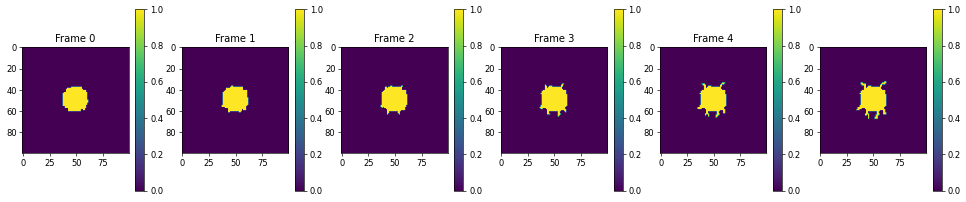

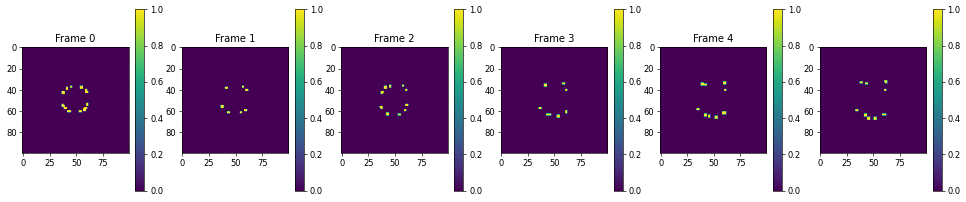

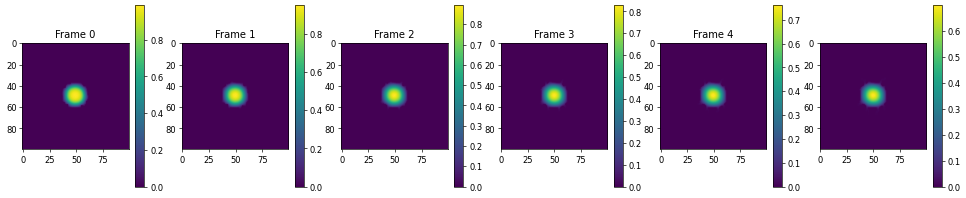

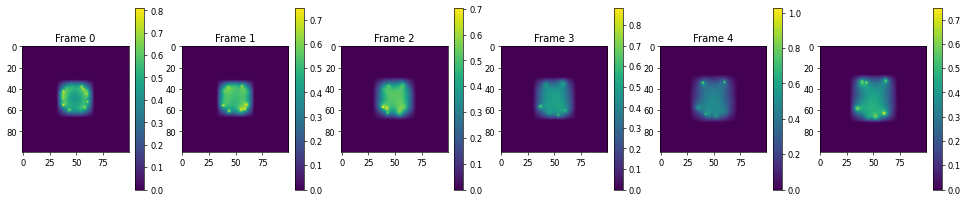

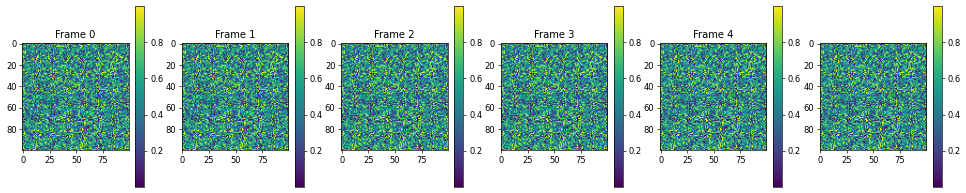

In [23]:
print(x_train.shape)
data_choice = np.random.choice(range(len(x_train)), size=1)[0]
print(data_choice)

for i in range(5):
    numFrame = 0
    plt.figure(figsize=(20, 4), dpi=60)
    for j in range(5):
        plt.subplot(1,6,numFrame+1)
        plt.imshow(x_train[data_choice,j,:,:,i])
        plt.colorbar()
        plt.title(f"Frame {numFrame}")
        numFrame += 1
    plt.subplot(1,6,numFrame+1)
    plt.imshow(y_train[data_choice,0,:,:,i])
    plt.colorbar()
    numFrame += 1

In [24]:
# from tensorflow.keras import layers
# inp = layers.Input(shape=(x_train.shape[1:]))

# # drop_rate = 0.1
# x0 = layers.TimeDistributed(layers.Conv2D(
#     filters=64,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(inp)
# x1 = layers.TimeDistributed(layers.Conv2D(
#     filters=128,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x0)
# x2 = layers.ConvLSTM2D(
#     filters=128,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=False,
#     activation="relu",
#     # recurrent_dropout=drop_rate,
# )(x1)
# x2 = tf.expand_dims(x2,axis=1)
# # x3 = layers.Concatenate(axis=4)([x1,x2])
# x4 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=64,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x2)
# # ))(x3)
# # x5 = layers.Concatenate(axis=4)([x0,x4])
# x6 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x4)
# # ))(x5)
# # x6 = layers.Dropout(drop_rate)(x6)

In [34]:
from tensorflow.keras import layers
inp = layers.Input(shape=(x_train.shape[1:]))

# drop_rate = 0.1
x0 = layers.TimeDistributed(layers.DepthwiseConv2D(
    depth_multiplier=12,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
x1 = layers.TimeDistributed(layers.DepthwiseConv2D(
    depth_multiplier=2,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x0)
x2 = layers.ConvLSTM2D(
    filters=120,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=False,
    activation="relu",
    # recurrent_dropout=drop_rate,
)(x1)
x2 = tf.expand_dims(x2,axis=1)
# x3 = layers.Concatenate(axis=4)([x1,x2])
x4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x2)
# ))(x3)
# x5 = layers.Concatenate(axis=4)([x0,x4])
x6 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=5,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x4)
# ))(x5)
# x6 = layers.Dropout(drop_rate)(x6)

In [35]:
def get_deriv(input):
    N1N_input, NN1_input = tf.image.image_gradients(input)
    N2N_input, _ = tf.image.image_gradients(N1N_input)
    _, NN2_input = tf.image.image_gradients(NN1_input)
    LAP_input = tf.math.add(N2N_input,NN2_input)
    return N1N_input, NN1_input, N2N_input, NN2_input, LAP_input

def PINN_loss():
    def loss(y_true, y_pred):
        # need to figure the correct dt, and T_pre
        dt = 0.01*100
        # variables should be from inp ***** (INCORRECT AT THE MOMENT)
        # tempr_pre = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        true_slice = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        pred_slice = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        theta = tf.experimental.numpy.copy(true_slice)
        # theta = tf.Variable([true_slice])
        # tf.assign(theta[theta>1],0)

        NN_p = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        tub_pre = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        NN_pK = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)

        # N1N_pK, NN1_pK, N2N_pK, N2N_pK, LAP_pK = get_deriv(NN_pK)
        N1N_p, NN1_p, _, _, LAP_p = get_deriv(NN_p)
        N1N_theta, NN1_theta, _, _, _ = get_deriv(theta)
        # _, _, _, _, LAP_tp = get_deriv(tempr_pre)
        N1N_tb, NN1_tb, _, _, LAP_tb = get_deriv(tub_pre)

        # Temperature calculation
        # tempr = (3*LAP_tp+4*(NN_pK - NN_p)/dt)*dt + tempr_pre
        tempr = (4*(NN_pK - NN_p)/dt)*dt

        # Tubulin Equation
        diff_tb = 4*(tf.math.multiply(N1N_p,N1N_tb) + tf.math.multiply(NN1_p,NN1_tb) + tf.math.multiply(NN_p,LAP_tb))
        alph_tb = 0.001*(tf.math.multiply(N1N_p,tub_pre) + tf.math.multiply(NN_p,N1N_tb) + tf.math.multiply(NN1_p,tub_pre) + tf.math.multiply(NN_p,NN1_tb))
        beta_tb = 0.001*tf.math.multiply(NN_p,tub_pre)
        src_tb = tf.math.divide_no_nan(15*tf.math.square(LAP_p),tf.math.reduce_sum(tf.math.square(LAP_p)))
        tub_K = (diff_tb - alph_tb - beta_tb + src_tb)*dt + tub_pre

        # Energy calculation
        E = 0.2865*tf.math.atan(10*tf.math.multiply(5*tub_K-0.1,1-tempr))

        # phase field equation residual
        atheta = tf.math.atan2(NN1_p,N1N_p)
        a = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-theta)))
        ap = -0.04*(6*0.1*tf.math.sin(6*(atheta-theta)))
        aap = tf.math.multiply(a,ap)
        a2 = tf.math.square(a)
        a2Lap = tf.math.multiply(a2,LAP_p)
        N1N_aapNN1p, _ = tf.image.image_gradients(tf.math.multiply(aap,NN1_p))
        _, NN1_aapN1Np = tf.image.image_gradients(tf.math.multiply(aap,N1N_p))
        mag_theta = tf.math.sqrt(tf.math.square(N1N_theta) + tf.math.square(NN1_theta))
        dblwll_term = tf.math.multiply(tf.math.multiply(NN_p,1-NN_p),NN_p - 0.5 + E + 6*0.007*mag_theta)
        phi_residual = a2Lap - N1N_aapNN1p + NN1_aapN1Np + dblwll_term - (NN_pK - NN_p) / dt
        
        residual = tf.math.reduce_mean(phi_residual)
        y_MSE = tf.math.reduce_mean(tf.square(tf.math.subtract(y_true[0,0,:,:,0], y_pred[0,0,:,:,0])))
        print(y_MSE)
        
        return y_MSE
    return loss

In [36]:
model = keras.models.Model(inp, x6)
model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    # loss=PINN_loss(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-6))
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 100, 100, 5)]  0         
                                                                 
 time_distributed_8 (TimeDis  (None, 5, 48, 48, 60)    1560      
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 5, 22, 22, 120)   3120      
 tributed)                                                       
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 22, 22, 120)       2880480   
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 1, 22, 22, 120)   0         
 a)                                                              
                                                           

In [37]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 2:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.hd5".format(epoch))

In [38]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_test_4')
else: 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

    epochs = 1000
    batch_size = 32
    saver = CustomSaver()

    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            # callbacks=[saver,early_stopping, reduce_lr],
            callbacks=[early_stopping, reduce_lr],
        )
        # model.run_eagerly = True

    model.save('./saved_model/model_conv_lstm_test_4') 

Epoch 1/1000
32/32 [==============================] - 9s 237ms/step - loss: 0.0873 - val_loss: 0.0876 - lr: 1.0000e-06
Epoch 2/1000
32/32 [==============================] - 6s 198ms/step - loss: 0.0873 - val_loss: 0.0876 - lr: 1.0000e-06
Epoch 3/1000
32/32 [==============================] - 6s 199ms/step - loss: 0.0873 - val_loss: 0.0876 - lr: 1.0000e-06
Epoch 4/1000
32/32 [==============================] - 6s 197ms/step - loss: 0.0872 - val_loss: 0.0875 - lr: 1.0000e-06
Epoch 5/1000
32/32 [==============================] - 6s 199ms/step - loss: 0.0872 - val_loss: 0.0875 - lr: 1.0000e-06
Epoch 6/1000
32/32 [==============================] - 6s 197ms/step - loss: 0.0871 - val_loss: 0.0874 - lr: 1.0000e-06
Epoch 7/1000
32/32 [==============================] - 6s 199ms/step - loss: 0.0871 - val_loss: 0.0874 - lr: 1.0000e-06
Epoch 8/1000
32/32 [==============================] - 6s 195ms/step - loss: 0.0870 - val_loss: 0.0873 - lr: 1.0000e-06
Epoch 9/1000
32/32 [============================

INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_4/assets


INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_4/assets


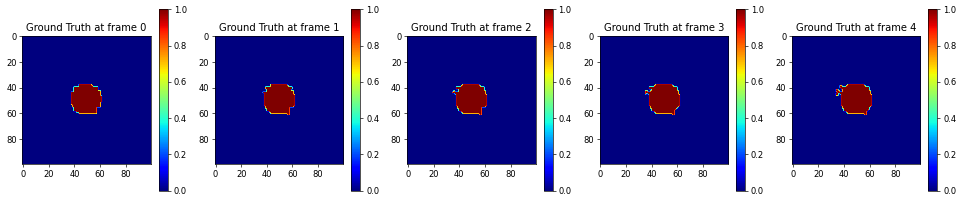

(1, 5, 100, 100, 5)

In [42]:
import matlab.engine
import copy
eng = matlab.engine.start_matlab()

def push(input, cutoff):
    max_input = np.amax(input)
    output = copy.copy(input)
    output[input>cutoff*max_input] = 1
    output[input<=cutoff*max_input] = 0
    return output
    
rand_case = np.random.randint((len(val_dataset)))
example_x = val_dataset[rand_case,:,:,:,:]

plt.figure(figsize=(20, 4), dpi=60)
plt.subplot(1,5,1)
plt.imshow(example_x[0,:,:,0], cmap='jet')
plt.colorbar()
plt.title("Ground Truth at frame 0")
plt.subplot(1,5,2)
plt.imshow(example_x[1,:,:,0], cmap='jet')
plt.colorbar()
plt.title("Ground Truth at frame 1")
plt.subplot(1,5,3)
plt.imshow(example_x[2,:,:,0], cmap='jet')
plt.colorbar()
plt.title("Ground Truth at frame 2")
plt.subplot(1,5,4)
plt.imshow(example_x[3,:,:,0], cmap='jet')
plt.colorbar()
plt.title("Ground Truth at frame 3")
plt.subplot(1,5,5)
plt.imshow(example_x[4,:,:,0], cmap='jet')
plt.colorbar()
plt.title("Ground Truth at frame 4")
plt.show()

x_in = np.expand_dims(example_x[0:5,...],axis=0)
x_in.shape

/tmp/ipykernel_207317/2865246530.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(22, 4), dpi=60)


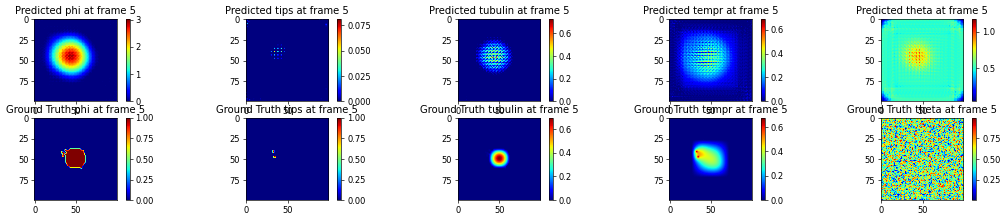

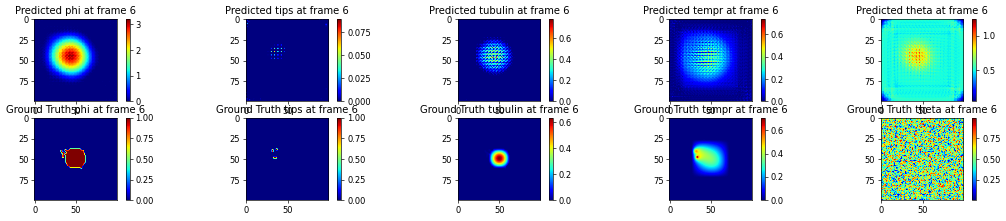

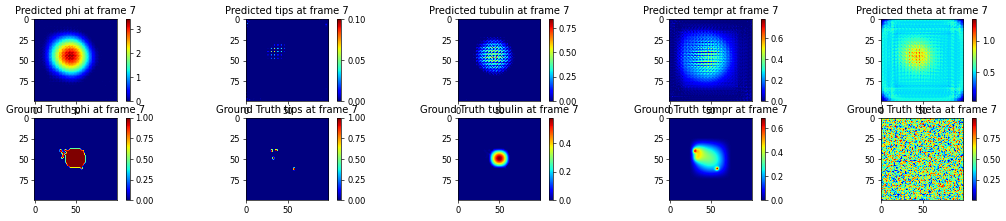

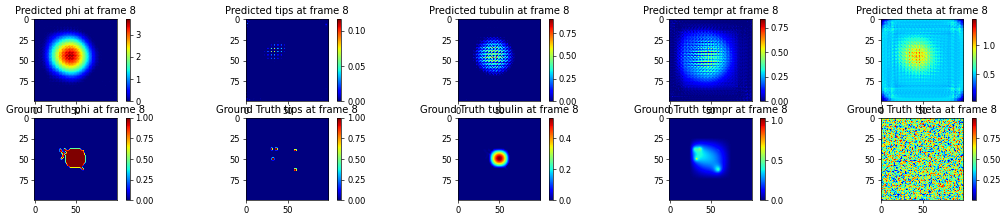

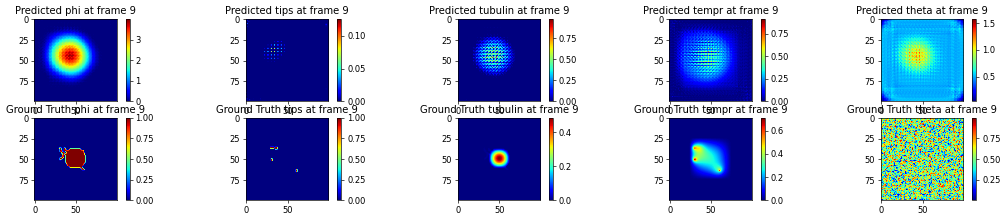

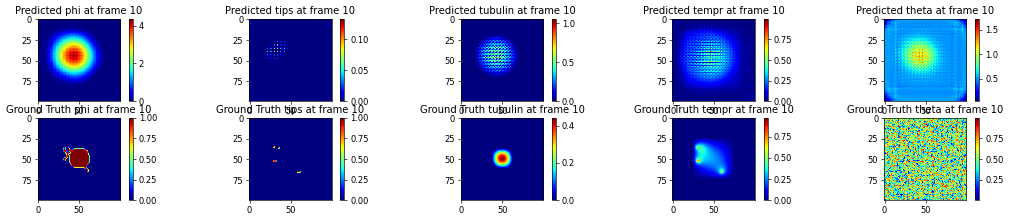

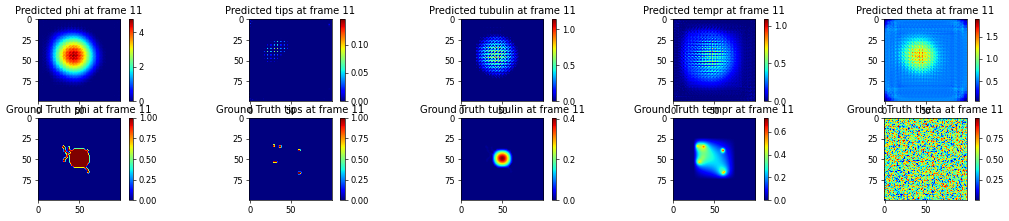

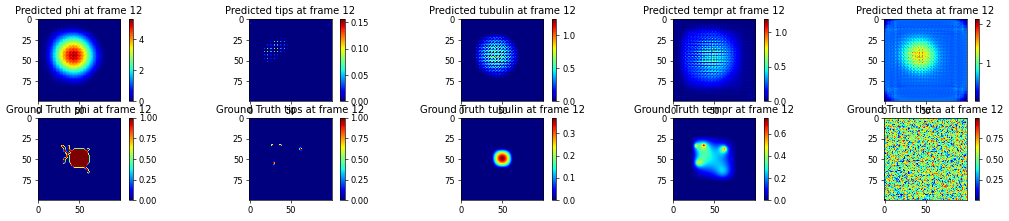

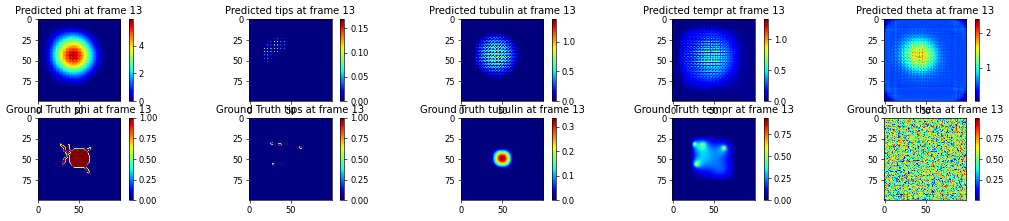

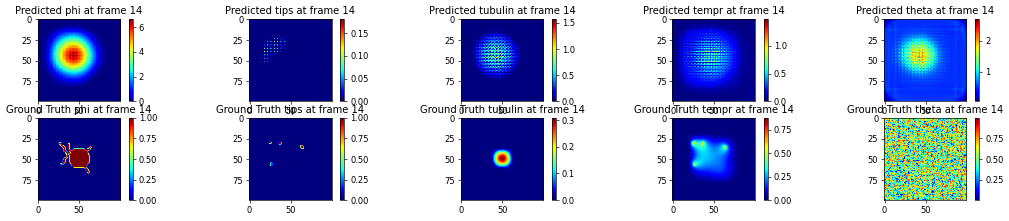

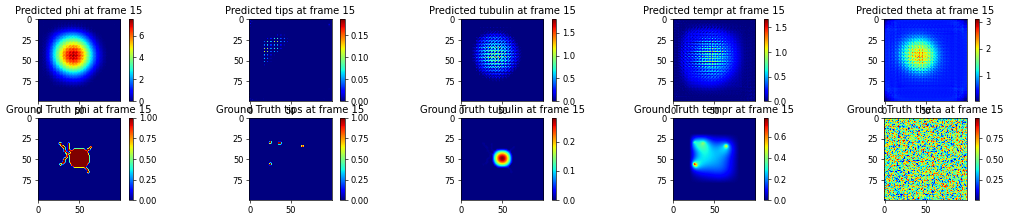

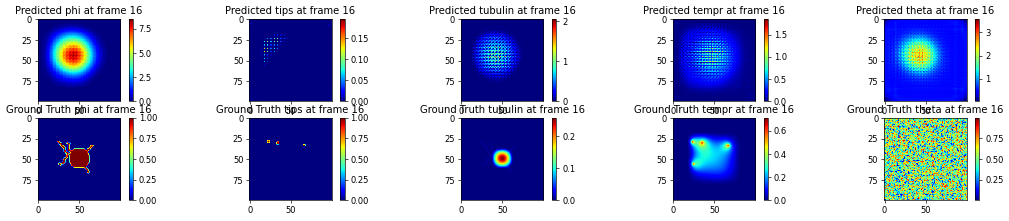

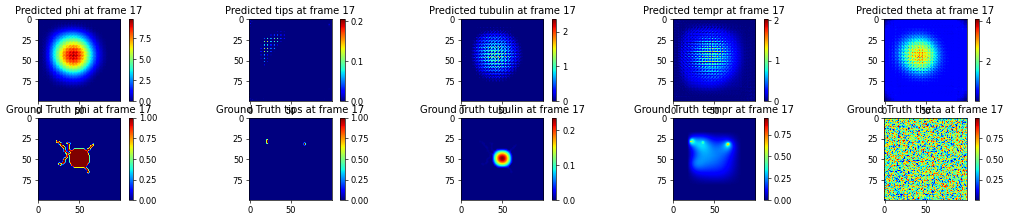

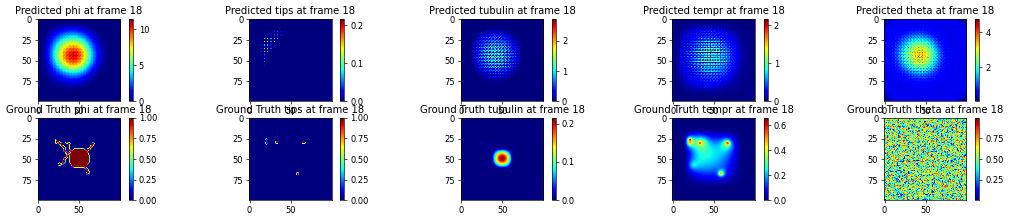

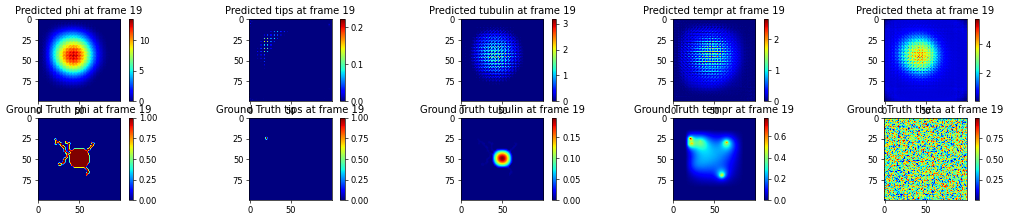

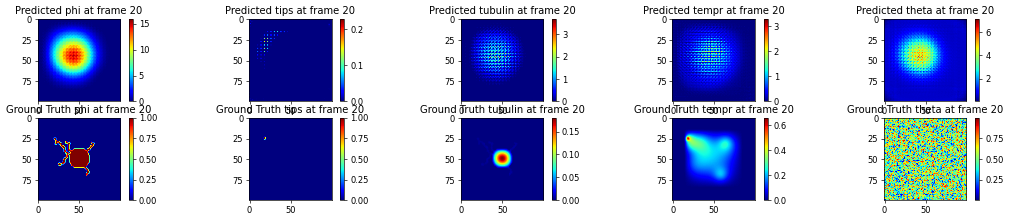

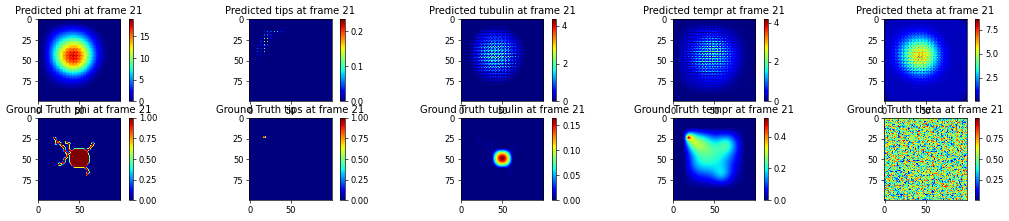

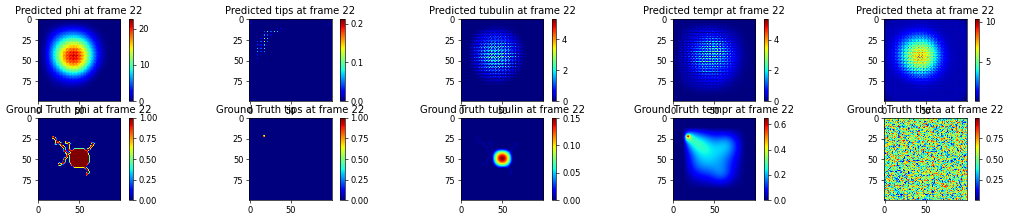

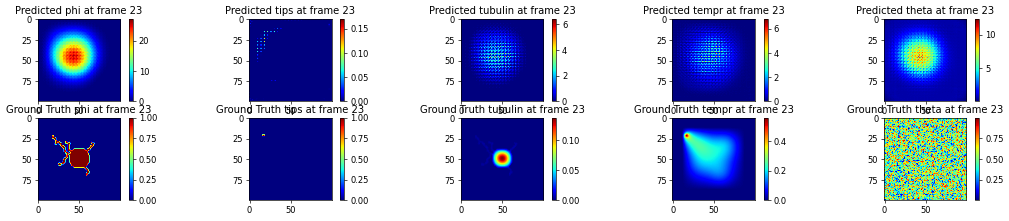

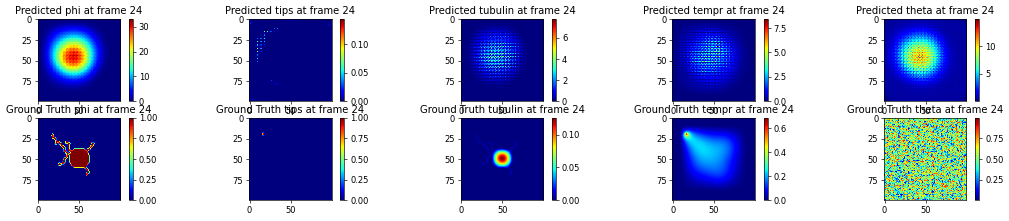

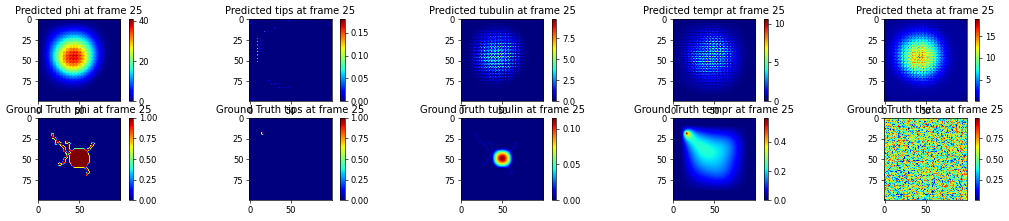

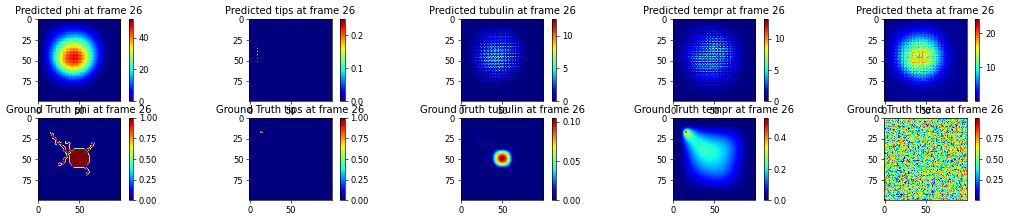

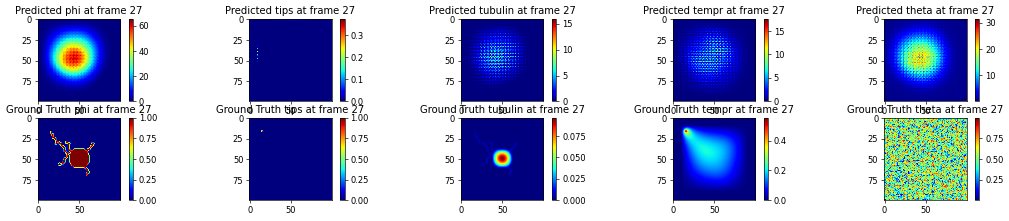

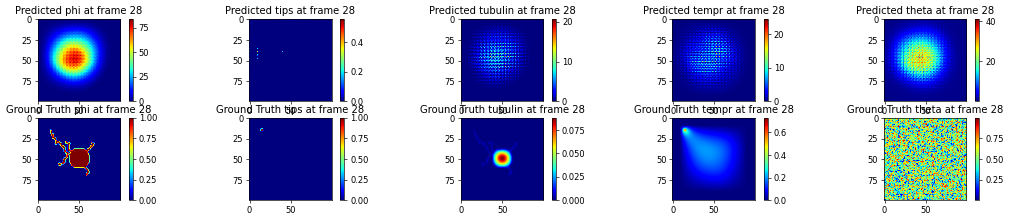

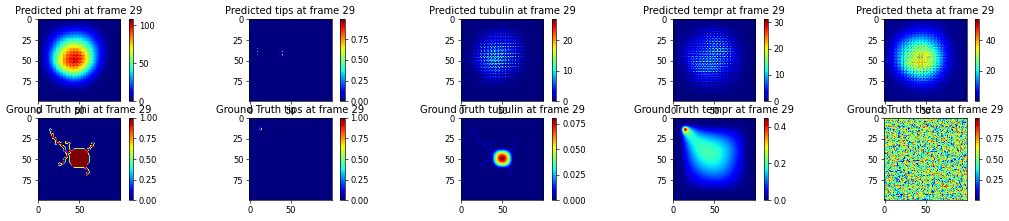

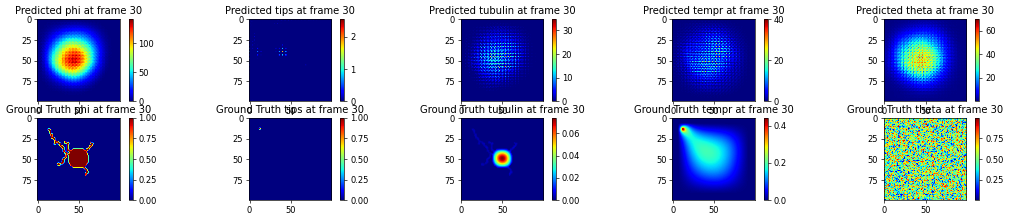

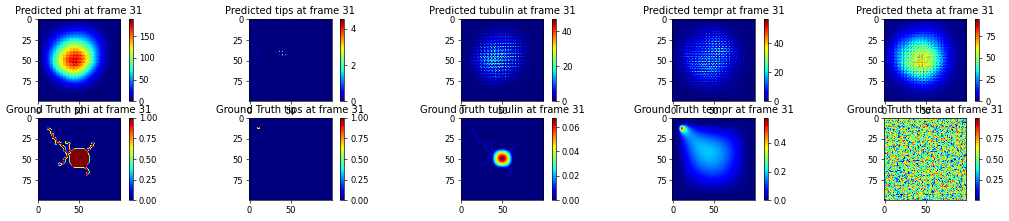

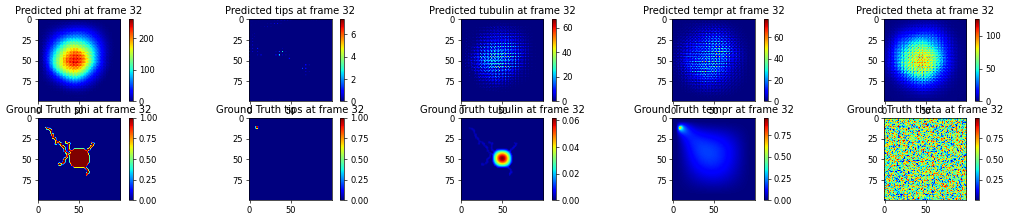

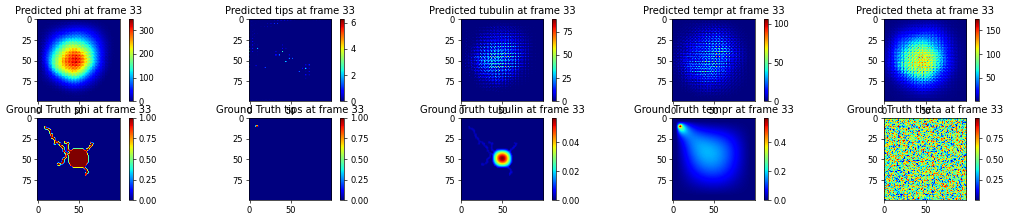

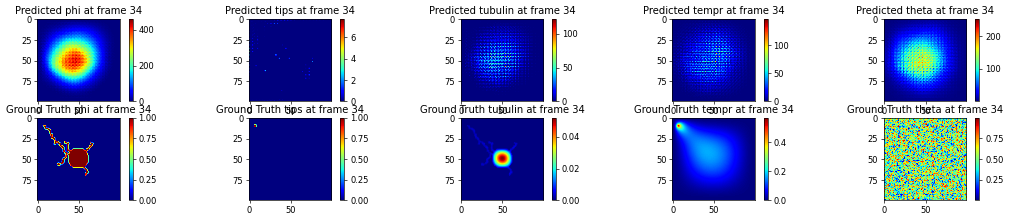

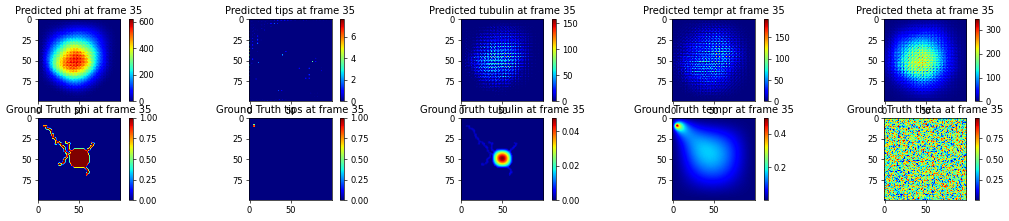

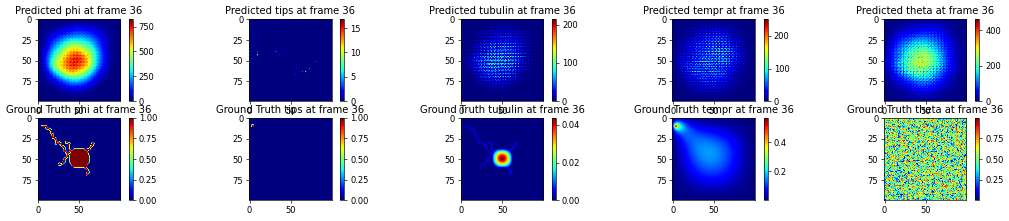

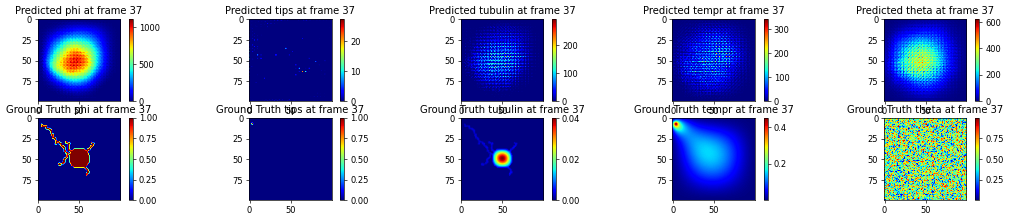

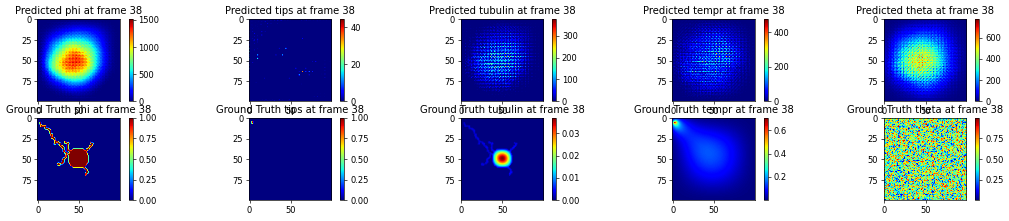

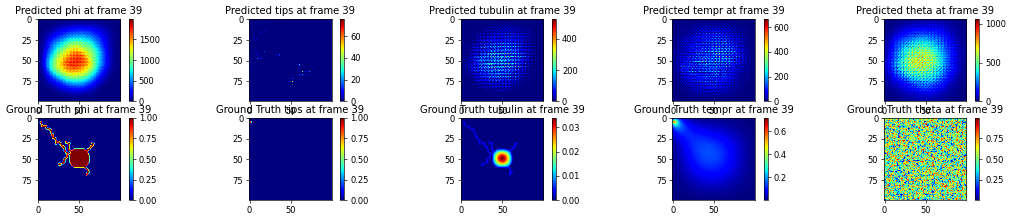

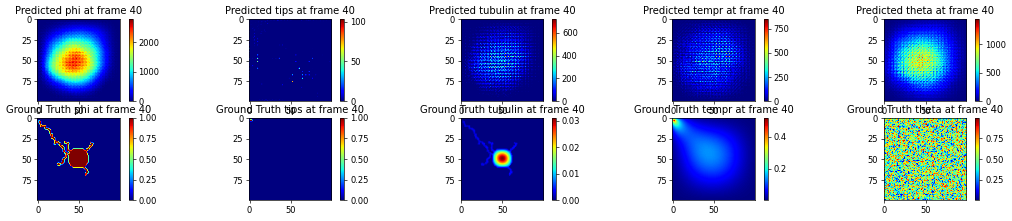

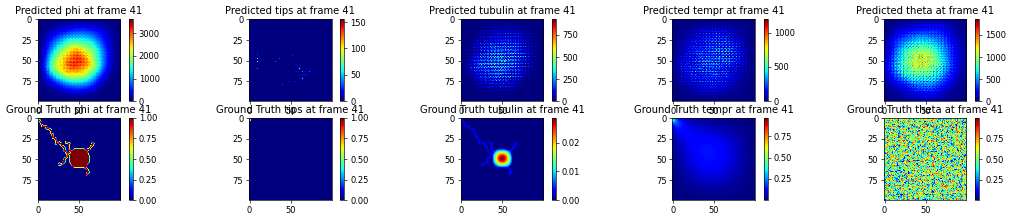

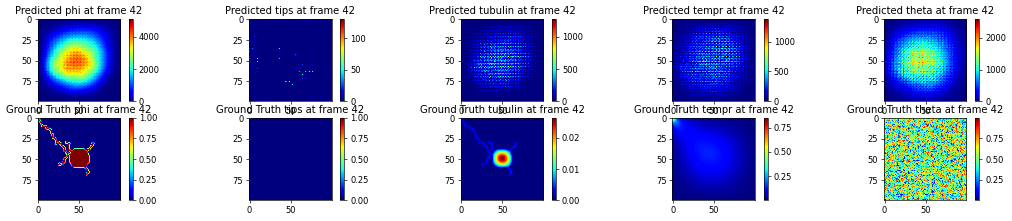

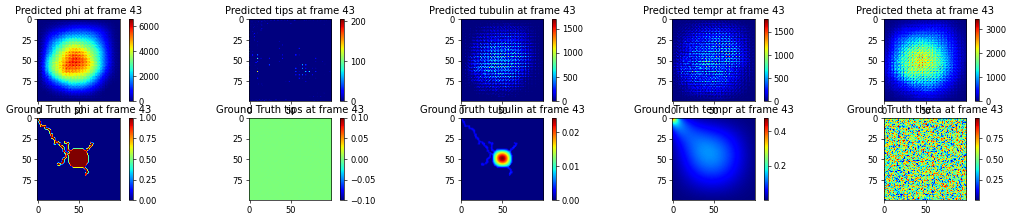

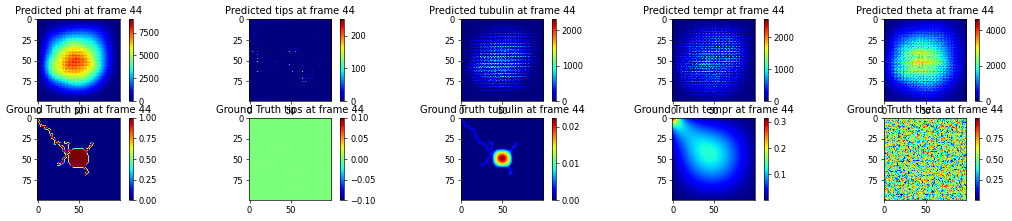

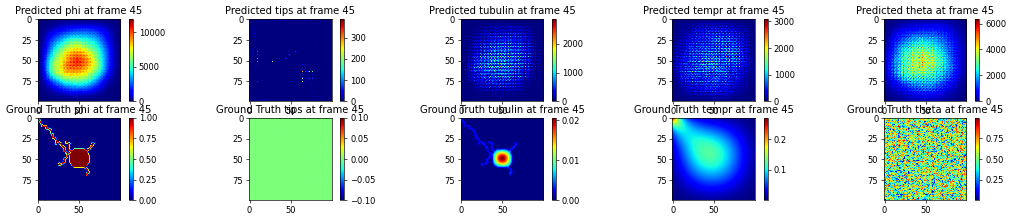

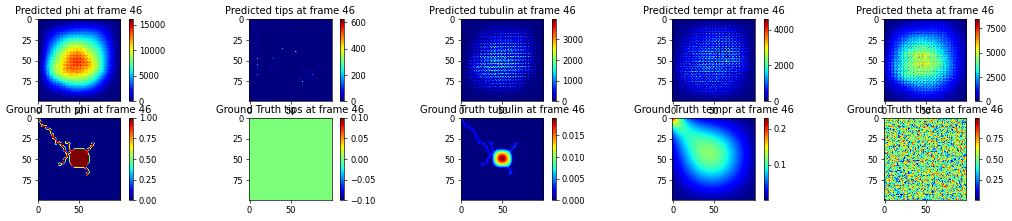

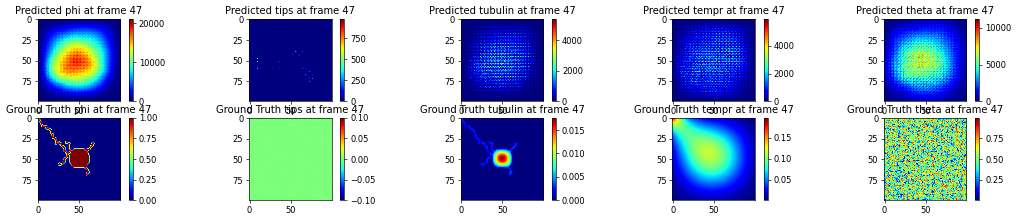

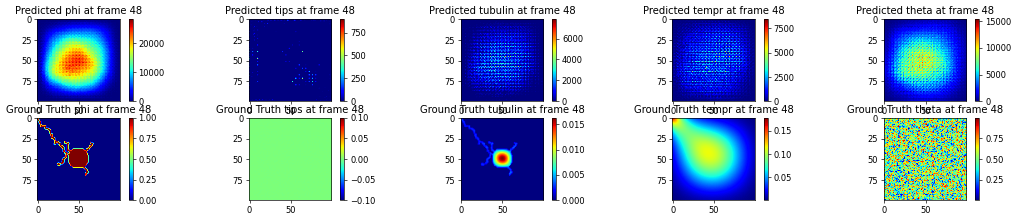

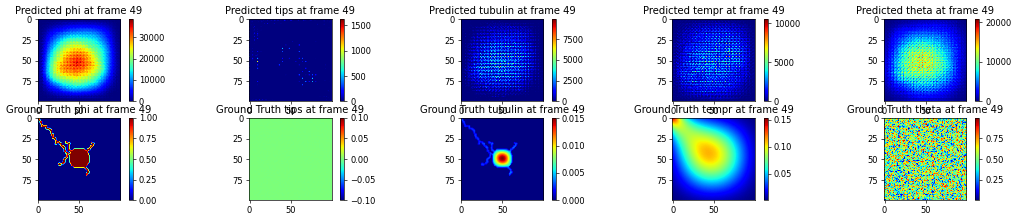

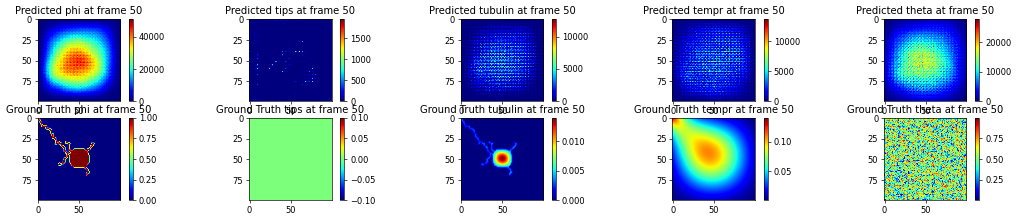

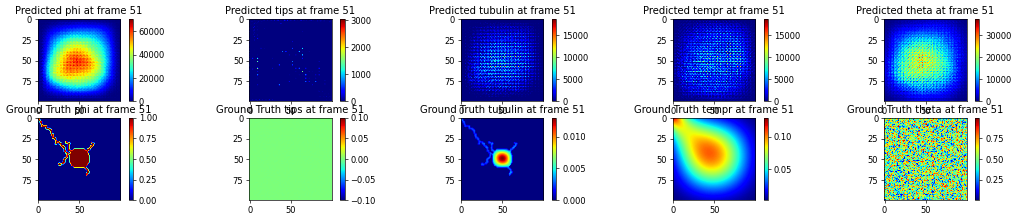

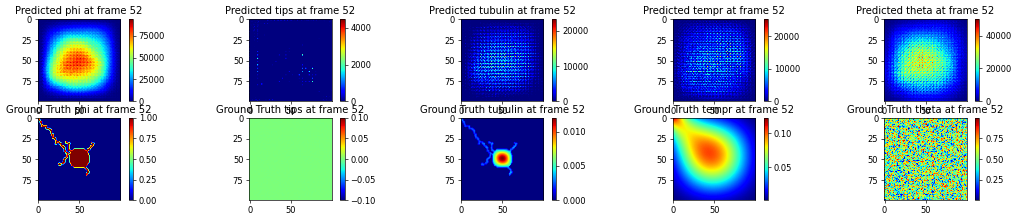

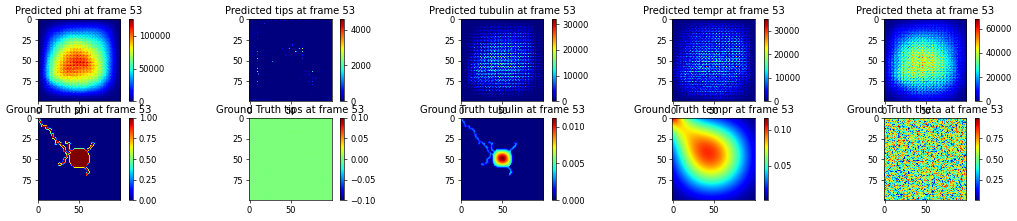

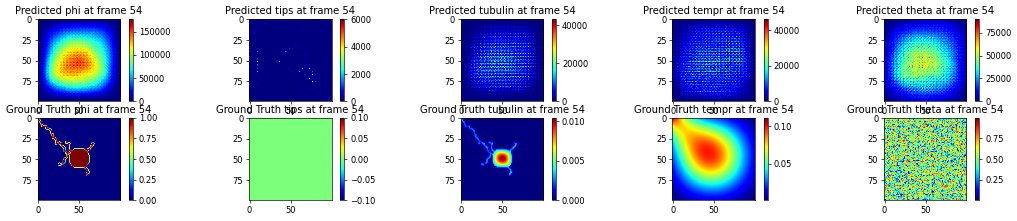

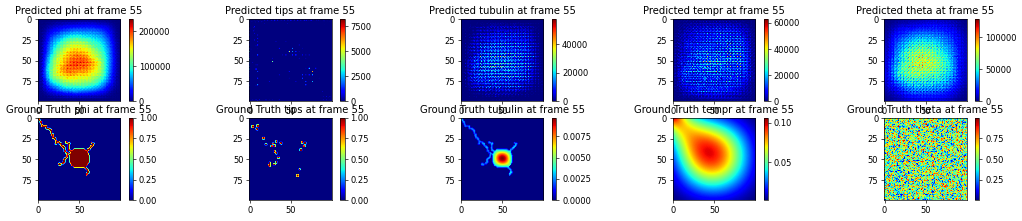

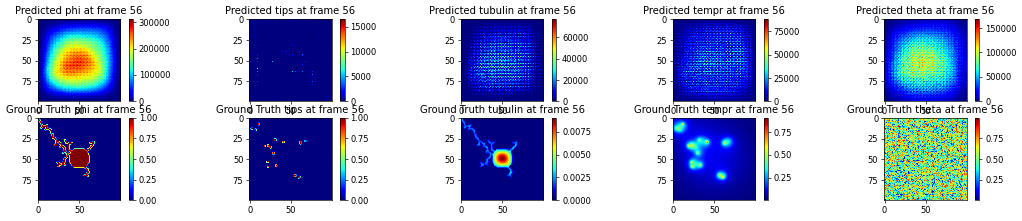

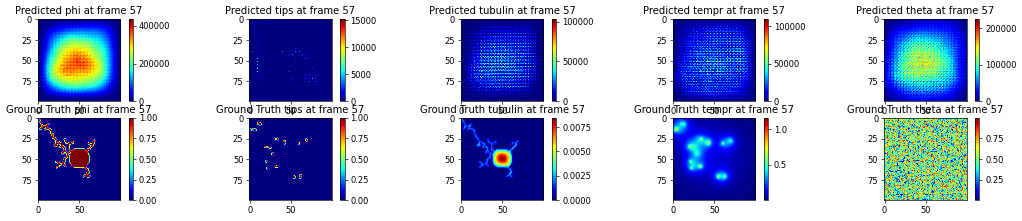

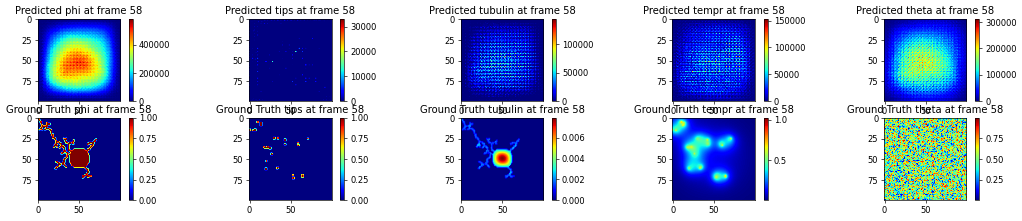

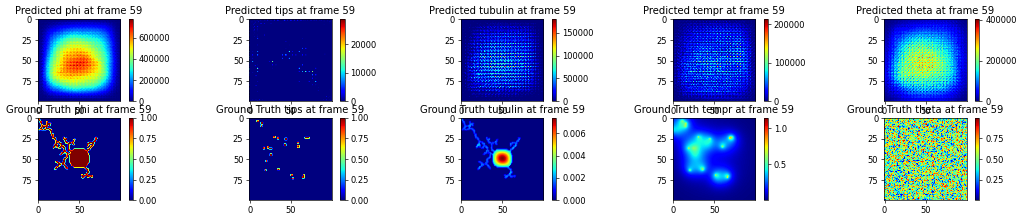

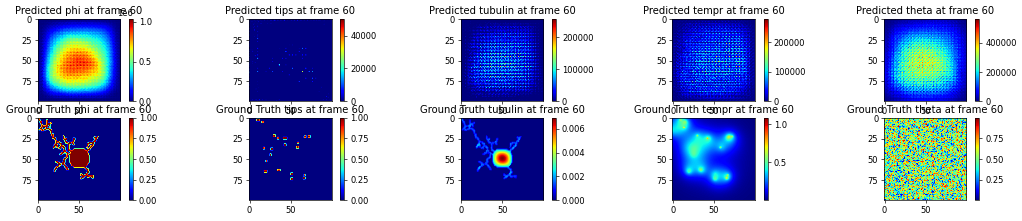

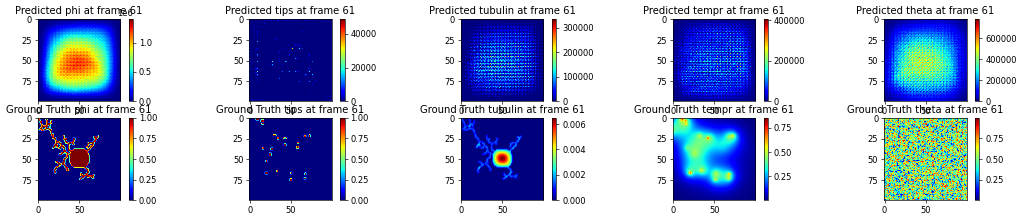

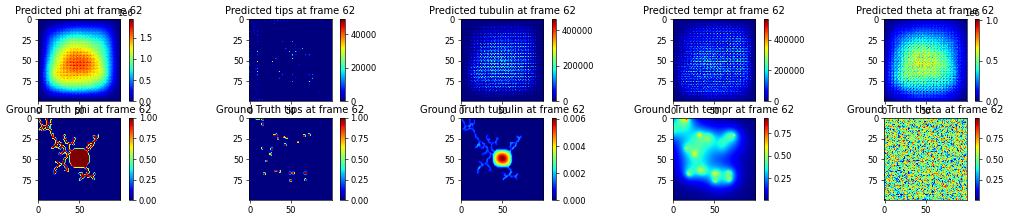

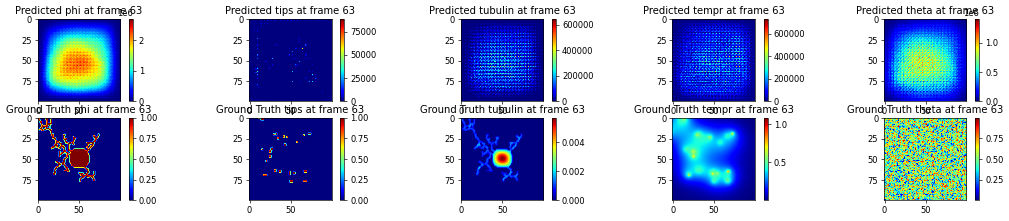

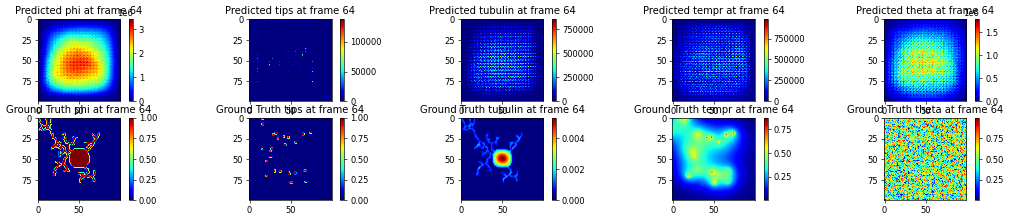

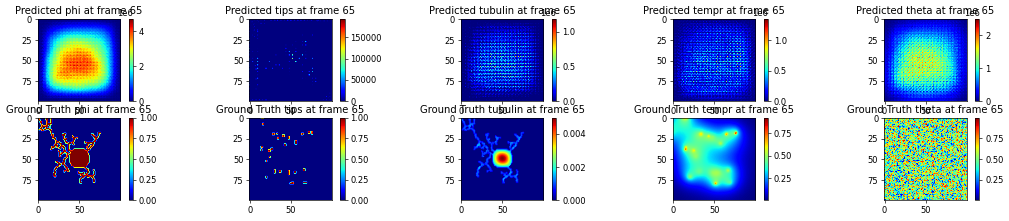

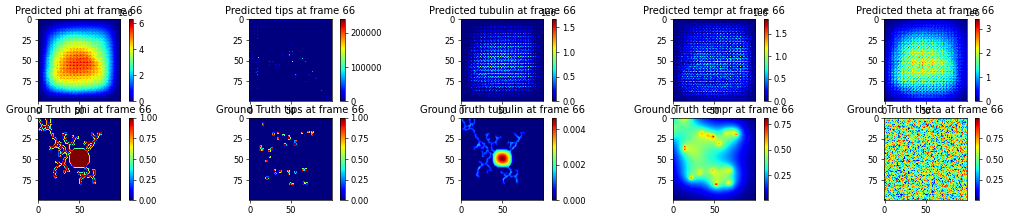

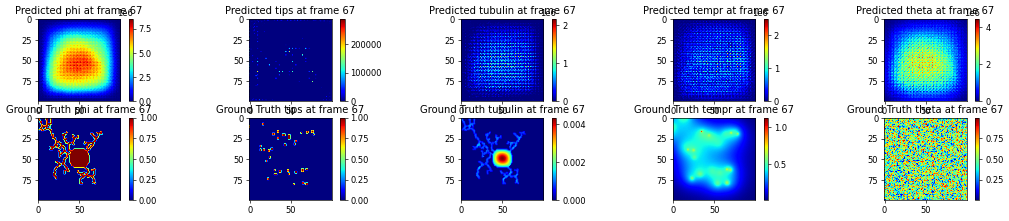

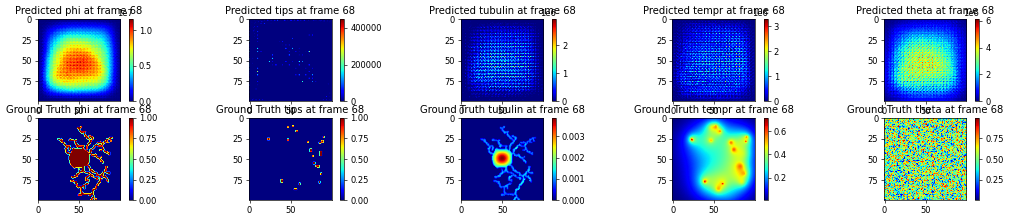

In [56]:
for i in range(64):
    new_prediction = model.predict(x_in,verbose="0")
    p_var = new_prediction[0,0,:,:,0]

    phi = new_prediction[0,0,:,:,0]
    tips = new_prediction[0,0,:,:,1]
    # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(phi).astype('float64')),5000))
    tub = new_prediction[0,0,:,:,2]
    tempr = new_prediction[0,0,:,:,3]
    theta = new_prediction[0,0,:,:,4]

    plt.figure(figsize=(22, 4), dpi=60)
    plt.subplot(2,5,1)
    plt.imshow(phi, cmap='jet')
    plt.colorbar()
    plt.title(f"Predicted phi at frame {i+5}")
    plt.subplot(2,5,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title(f"Predicted tips at frame {i+5}")
    plt.subplot(2,5,3)
    plt.imshow(tub, cmap='jet')
    plt.colorbar()
    plt.title(f"Predicted tubulin at frame {i+5}")
    plt.subplot(2,5,4)
    plt.imshow(tempr, cmap='jet')
    plt.colorbar()
    plt.title(f"Predicted tempr at frame {i+5}")
    plt.subplot(2,5,5)
    plt.imshow(theta, cmap='jet')
    plt.colorbar()
    plt.title(f"Predicted theta at frame {i+5}")

    plt.subplot(2,5,6)
    plt.imshow(example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth phi at frame {i+5}")
    plt.subplot(2,5,7)
    plt.imshow(example_x[i+5,:,:,1], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth tips at frame {i+5}")
    plt.subplot(2,5,8)
    plt.imshow(example_x[i+5,:,:,2], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth tubulin at frame {i+5}")
    plt.subplot(2,5,9)
    plt.imshow(example_x[i+5,:,:,3], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth tempr at frame {i+5}")
    plt.subplot(2,5,10)
    plt.imshow(example_x[i+5,:,:,4], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth theta at frame {i+5}")


    # plt.subplot(1,7,6)
    # plt.imshow(example_x[i+5,:,:,0], cmap='jet')
    # plt.colorbar()
    # plt.title(f"Ground Truth at frame {i+5}")
    # plt.subplot(1,7,7)
    # plt.imshow((example_x[i+5,:,:,0]-p_var)/(np.amax(example_x[i+5,:,:,0])-np.amin(example_x[i+5,:,:,0])), cmap='jet')
    # plt.colorbar()
    # plt.title(f"MRE at frame {i+5}")
    # plt.show()

    tmp = np.zeros(x_in.shape)
    tmp[0,0,...] = x_in[0,1,...]
    tmp[0,1,...] = x_in[0,2,...]
    tmp[0,2,...] = x_in[0,3,...]
    tmp[0,3,...] = x_in[0,4,...]
    tmp[0,4,...] = new_prediction[0,0,...]

    x_in = tmp